# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [370]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg, lit, desc
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import max as Fmax
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType, DateType, StringType, FloatType, TimestampType

import datetime
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import seaborn as sns 

register_matplotlib_converters()
%matplotlib inline
sns.set()

In [2]:
# Create the spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify Customer Churn Prediction") \
    .getOrCreate()

# Load and Clean Dataset
Load the `mini_sparkify_event_data.json` and clean the dataset from invalid/ missing data.

In [3]:
# Load the dataset
events = spark.read.json("mini_sparkify_event_data.json")
events.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [4]:
# Evaluate table schema
events.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
# Check for entries with missing userId
events.filter("userId is Null or userId == ''").show()

+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|          100|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355745000|     null|      |
|  null|Logged Out|     null|  null|          101|    null|  null| free|    null|   GET| Help|        null|        8|null|   200|1538355807000|     null|      |
|  null|Logged Out|     null|  null|          102|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355841000|     null|      |
|  null|Logged Out|     null|  nul

In [6]:
# Investigate auth status of users with missing userId
events.filter("userId is Null or userId == ''").select('auth').distinct().show()

+----------+
|      auth|
+----------+
|Logged Out|
|     Guest|
+----------+



In [7]:
# Check, if userId is missing for all entries with the above auth status
events.filter("auth in ('Logged Out','Guest')").select('userId').distinct().show()

+------+
|userId|
+------+
|      |
+------+



In [8]:
# Remove entries for logged out and guest users
events = events.filter("auth not in ('Logged Out', 'Guest')")
print("Entries with missing userId: {}".format(events.filter("userId is Null or userId == ''").count()))

Entries with missing userId: 0


In [9]:
# Check for entries with missing sessionId
print("Entries with missing sessionId: {}".format(events.filter("sessionId is Null or sessionId == ''").count()))

Entries with missing sessionId: 0


In [10]:
# Check for entries with missing ts (timestamp)
print("Entries with missing ts: {}".format(events.filter("ts is Null or ts == ''").count()))

Entries with missing ts: 0


In [11]:
# Check for entries with missing artist
print("Entries with missing artist: {}".format(events.filter("artist is Null or artist == ''").count()))
events.filter("artist is Null or artist == ''").show()

Entries with missing artist: 50046
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|           page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Logged In|    Colin|     M|           54| Freeman|  null| paid|     Bakersfield, CA|   PUT|Add to Playlist|1538173362000|       29|null|   200|1538352905000|Mozilla/5.0 (Wind...|    30|
|  null|Logged In|    Micah|     M|           84|    Long|  null| free|Boston-Cambridge-...|   GET|    Roll Advert|1538331630000|        8|null|   200|1538353150000|"Mozilla/5.0 (Win...|   

In [12]:
events.filter("artist is Null or artist == ''").select('page').distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [13]:
# Check unique values of gender
events.select('gender').distinct().show()

+------+
|gender|
+------+
|     F|
|     M|
+------+



**Conclusion Data Cleaning**

* Events with the authentication "Logged Out" and "Guest" are not provided with a userId (empty) and therefor have been removed from the dataset.
*Further more, 50046 events with missing artist could be identified. Those entries have been kept though, as they refernece different kinds of user interaction that may not be connected to a single artist (e.g. page == "Upgrade").

# Exploratory Data Analysis

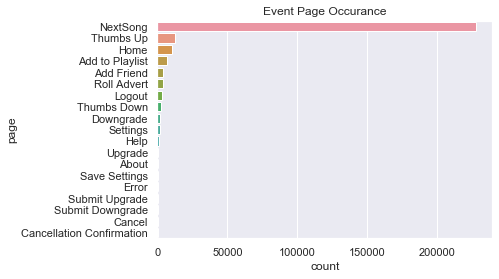

In [202]:
# Count occurance of different event pages 
sns.barplot(x='count', y='page', data=events.groupby('page').count().orderBy(desc('count')).toPandas())
plt.title('Event Page Occurance')
plt.show()

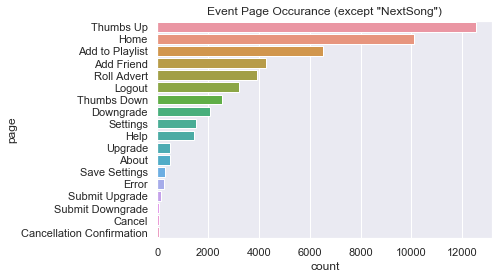

In [203]:
# Count occurance of different event pages (except "NextSong")
sns.barplot(x='count', y='page', data=events.filter('page != "NextSong"').groupby('page').count().orderBy(desc('count')).toPandas())
plt.title('Event Page Occurance (except "NextSong")')
plt.show()

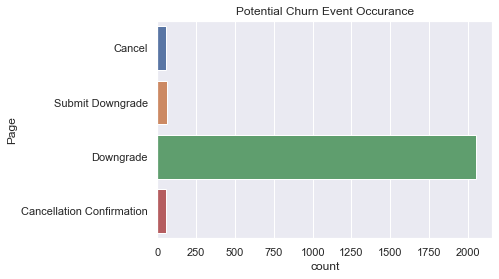

In [15]:
# Count occurance of potential churn events (when user comes to one of the four selected pages)
sns.barplot(x='count', y='page', data=events.filter("page in ('Cancel','Cancellation Confirmation','Downgrade', 'Submit Downgrade')").groupby('page').count().toPandas())
plt.title('Potential Churn Event Occurance')
plt.show()

### Define Churn

In [16]:
# Add column churn with 0 as default value
events = events.withColumn("churn", lit(0))
events.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|churn|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|    0|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|

In [17]:
# Identify all userIds with churn event
churn_userIds = list(events.filter("page in ('Cancellation Confirmation','Submit Downgrade')").select('userId').distinct().toPandas()['userId'])

In [19]:
# Set churn to 1 for all events of a churn user
events = events.withColumn("churn", when(col("userId").isin(churn_userIds), 1).otherwise(col("churn")))
events.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|churn|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|    1|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|

**Conclusion Define Chrun**

Churn has been defined as any event that leads the user to the "Cancellation Confirmation" or "Submit Downgrade" page. The "Submit Downgrade" page may not be an equally certain indicator for churn as the "Cancellation Confirmation" page. Anyhow, it still seems like the more valid option compared to the "Downgrade" page, looking at how often this page occurs over all events vs. the occurance of "Cancellation Confirmation" and "Submit Downgrade". Further more, it is assumed that a user, who gets to the "Submit Downgrade" page is more likely to churn, even if he does not actually submits the downgrade just in that moment.


### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

**Class balance**

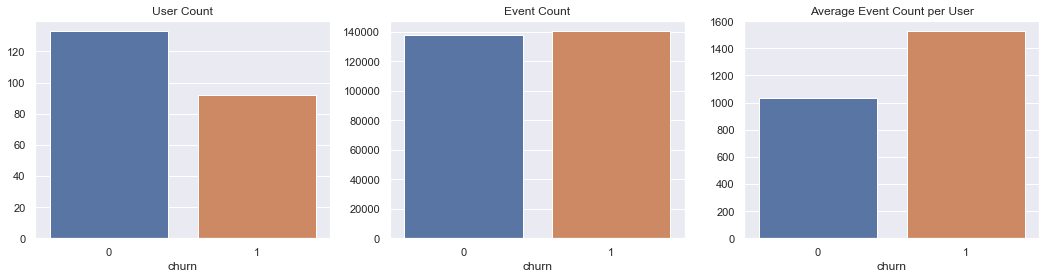

In [124]:
# Check the class balance withing the dataset

fig, ax = plt.subplots(1, 3, figsize=(18,4))

# Count of users (churn vs. no churn)
sns.barplot(x='churn', y='count', data=events.select(['churn','userId']).distinct().groupby('churn').count().toPandas(), ax=ax[0])
ax[0].set_title('User Count')
ax[0].set_ylabel('')

# Event count (churn vs. no churn)
sns.barplot(x='churn', y='count', data=events.select(['churn','userId']).groupby(['churn']).count().toPandas(), ax=ax[1])
ax[1].set_title('Event Count')
ax[1].set_ylabel('')

# Average event count per user (churn vs. no churn)
avg_events_churn_0 = events.filter('churn == 0').select(['userId']).groupby('userId').count().toPandas()['count'].mean()
avg_events_churn_1 = events.filter('churn == 1').select(['userId']).groupby('userId').count().toPandas()['count'].mean()
sns.barplot(x=[0,1], y=[avg_events_churn_0, avg_events_churn_1], ax=ax[2])
ax[2].set_title('Average Event Count per User')
ax[2].set_xlabel('churn')

plt.show()

*Conclusion: Class balance*

The first plots show, that the dataset contains more users who did not churn (133 users) compared to those who did (92 users). Anyhow, this imbalance disappears when looking at the total event counts from churned users vs. not churned users, due to the fact that the group of churned users shows a higher number of events per user (in average).

**Share of most common events**

In [140]:
avg_events_churn_without_nextsong = events.filter('churn == 0 and page != "NextSong"').select(['userId']).groupby('userId').count().toPandas()['count'].mean()
avg_events_no_churn_without_nextsong = events.filter('churn == 1 and page != "NextSong"').select(['userId']).groupby('userId').count().toPandas()['count'].mean()

def get_page_count_per_user_by_churn(df, page, as_pandas=True):
    '''
    Parameters: 
        df (spark dataframe) - The dataframe that holds the events
        page (String) - The name of the page to filter the events by
        as_pandas (Boolean) - Wether the resultung dataframe should get transformed to a Pandas dataframe
    
    Return:
        dataframe (spark or pandas) - The average event counts per user for the given page grouped by churn
    
    This function
        - Counts the occurance of the given page grouped by user and churn
        - Calculates the average occurance of the given page per user by churn
        - Calculates the share of the page event occurance compared to the average count of all events (except "Next Song", as this is by far the most common event that would make the other page events harder to compare) 
    '''
    event_counts = events.filter('page == "{}"'.format(page)) \
        .groupby('userId') \
        .agg({'userId': 'count', 'churn': 'max'}) \
        .withColumnRenamed("max(churn)", "churn") \
        .groupBy('churn') \
        .agg(avg('count(userId)').alias('avg_count_per_user')) \
        .withColumn('share_events_without_nextsong', when(col('churn')==0, col('avg_count_per_user')/avg_events_churn_without_nextsong*100).otherwise(col('avg_count_per_user')/avg_events_no_churn_without_nextsong*100))
    
    return event_counts.toPandas() if as_pandas else event_counts.select()

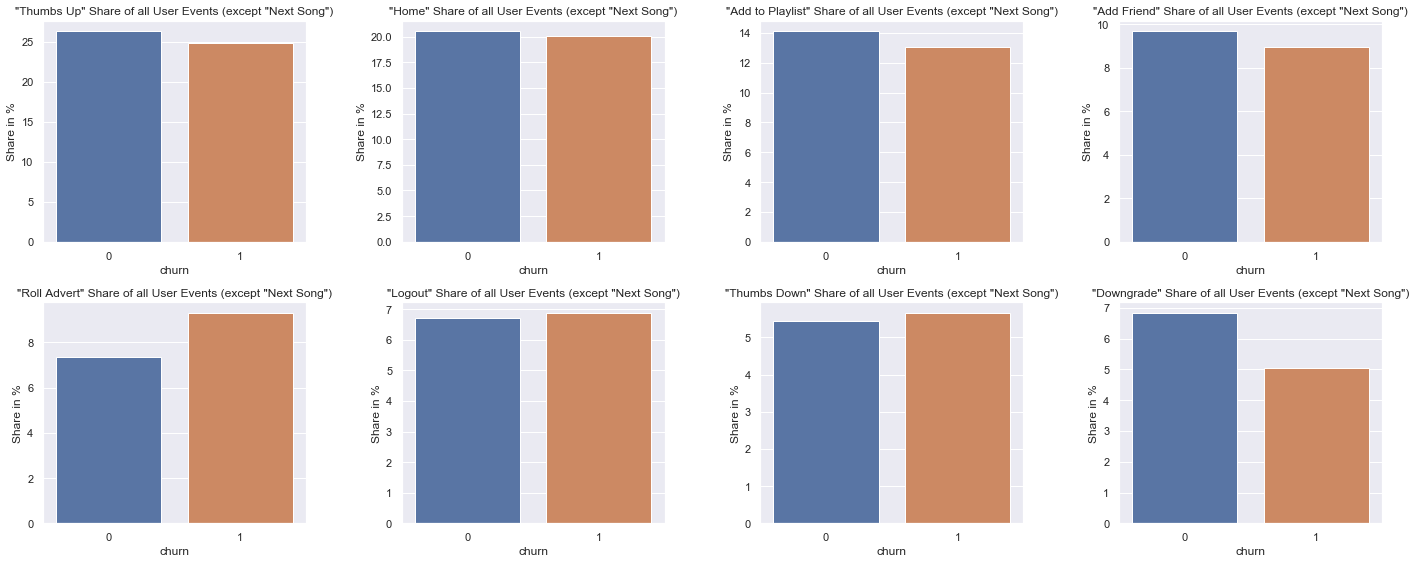

In [201]:
# Check the average occurance of the most common page events (except "Next Song") for churned vs. not churned users
most_common_pages = events.filter('page != "NextSong"').groupby('page').count().orderBy(desc('count')).toPandas()['page']
pages = [list(most_common_pages[:4]), list(most_common_pages[4:8])]

fig, ax = plt.subplots(len(pages), len(pages[0]), figsize=(len(pages[0])*5,len(pages)*4))
for i, ps in enumerate(pages):
    for j, p in enumerate(ps): 
        sns.barplot(x='churn', y='share_events_without_nextsong', data=get_page_count_per_user_by_churn(events, p), ax=ax[i][j])
        ax[i][j].set_title('"{}" Share of all User Events (except "Next Song")'.format(p))
        ax[i][j].set_ylabel('Share in %')
plt.tight_layout()
plt.show()

*Conclusion: Share of most common events*

Share of most common events: The second set of plots shows the share of the most common page events compared to all events (except "NextSong") per user and churn. We can see, that churned users show a higher share of ```Roll Advert``` events. On the other hand, churned users have a lower share of ```Add Friend```, ```Add to Playlist```, ```Thumbs Up``` and ```Downgrade``` events. Unfortunatelly, no documentation on how to interpret "Downgrade" events could be found. As mentioned above, it is assumed, that "Submit Downgrade" actually indicates the user really attempts to downgrade the subscription. We could only guess, in which realtion the "Downgrade" page stands to the actual event. Anyhow, as this event type might be useful for the model to distinguish between users who might churn and those who won't, we will hold on to it.

**Songs per Session**

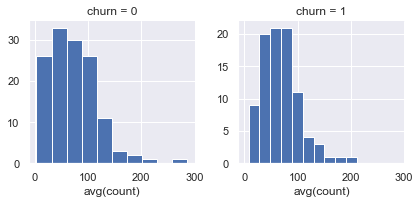

In [177]:
# Plot average number of songs played per session (Page "NextSong")
songs_per_session = events.filter('page == "NextSong"') \
    .groupby(['churn', 'userId', 'sessionId']) \
    .count() \
    .groupby(['userId', 'churn']) \
    .agg({'count': 'avg'}).toPandas()
g = sns.FacetGrid(songs_per_session, col="churn", sharey=False)
g.map(plt.hist, "avg(count)");

*Conclusion: Songs per Session*

Both churned and not churned users usually listened to max 100 songs per session. Overall, the distribution for the amount of songs listend to per sessions seems quite similar for both groups.

**Songs and Length per Day**

In [378]:
datetime_func = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0), DateType())
month_func = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).month, IntegerType())
day_func = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day, IntegerType())
hour_func = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour, IntegerType())
week_func = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).isocalendar()[1], IntegerType())
year_func = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).year, IntegerType())

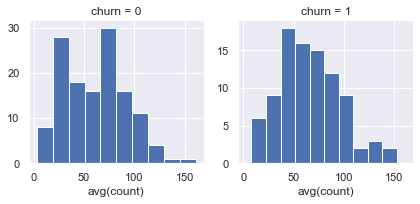

In [337]:
# Plot average number of songs played per day (Page "NextSong")
songs_per_session = events.filter('page == "NextSong"') \
    .withColumn("date", datetime_func(events.ts)) \
    .groupby(['churn', 'userId', 'date']) \
    .count() \
    .groupby(['userId', 'churn']) \
    .agg({'count': 'avg'}).toPandas()
g = sns.FacetGrid(songs_per_session, col="churn", sharey=False)
g.map(plt.hist, "avg(count)");

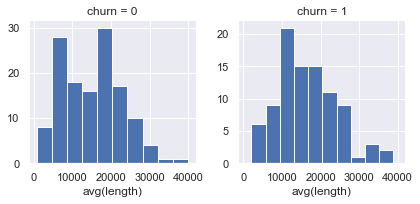

In [342]:
# Plot average length played per day (Page "NextSong")
songs_per_session = events.filter('page == "NextSong"') \
    .withColumn("date", datetime_func(events.ts)) \
    .groupby(['churn', 'userId', 'date']) \
    .agg(Fsum('length').alias('length')) \
    .groupby(['userId', 'churn']) \
    .agg({'length': 'avg'}).toPandas()
g = sns.FacetGrid(songs_per_session, col="churn", sharey=False)
g.map(plt.hist, "avg(length)");

*Conclusion: Songs and Length per Day*
    
The above plots show that the distributions of the average number of songs and the avreage lenght per day are very similar. Further more, we can clear differences between churned vs. not churned users. Thus, either ```avg_daily_length``` or ```avg_daily_song_count``` coud be a good feature choice.

**Churn Events over Time**

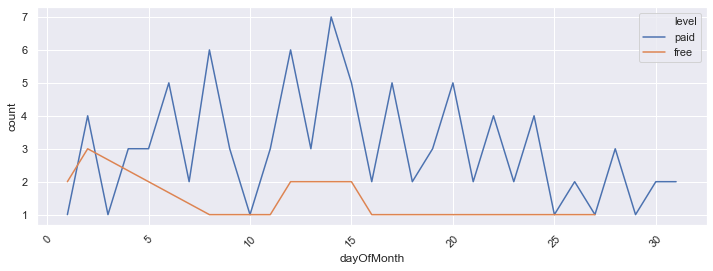

In [390]:
# PLot the count of churn events per day of month
events_per_day = events.filter(col('page').isin('Cancellation Confirmation', 'Submit Downgrade')) \
    .withColumn("dayOfMonth", day_func(events.ts)) \
    .groupby('dayOfMonth', 'level') \
    .count() \
    .sort('dayOfMonth').toPandas()

fig = plt.figure(figsize=(12, 4))
sns.lineplot(x='dayOfMonth', y='count', hue='level', data=events_per_day)
plt.xticks(rotation=45)
plt.show()

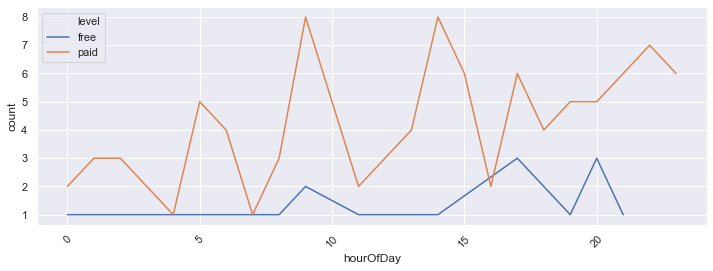

In [391]:
# PLot the count of churn events per hour of day
events_per_hour = events.filter(col('page').isin('Cancellation Confirmation', 'Submit Downgrade')) \
    .withColumn("hourOfDay", hour_func(col('ts'))) \
    .groupby('hourOfDay', 'level') \
    .count() \
    .sort('hourOfDay').toPandas()

fig = plt.figure(figsize=(12, 4))
sns.lineplot(x='hourOfDay', y='count', hue='level', data=events_per_hour)
plt.xticks(rotation=45)
plt.show()

*Conclusion: Churn Events over Time*

No big surprises occur looking at the cancellation and downgrade events by day of month and hour of day. We can see a slightly higher churn frequency in the middel of the month. When it comes to the hour of day, the churn frequency during the night hours is lower then during the day hours. It could be further investigated wether this trend differs when taking the location/ timezone of the user into account. Anyhow, as the number of churn events is already quite small, seeing an actual trend within an even smaller set of churn events (e.g. filtert by timezone) seems very unlikely.

**Weekly Event Count**

In [282]:
weekly_events = events.withColumn("week", week_func(events.ts)).groupby('userId','churn','week').count().sort('week').toPandas()

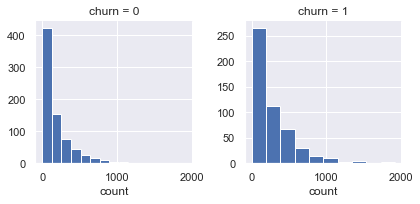

In [283]:
g = sns.FacetGrid(weekly_events, col="churn", sharey=False)
g.map(plt.hist, "count");

**Event Count Change Rate**

How does the amount of events per user change over time?

**Days between Registration and Cancellation**

In [331]:
# Time to Cancellation
days_to_cancel = events.withColumn('cancellationTs', when(col('page') == 'Cancellation Confirmation', events.ts).otherwise(0)) \
    .groupby('userId', 'registration') \
    .agg(Fmax('cancellationTs').alias('cancellationTs')) \
    .withColumn('days_to_cancel', when(col('cancellationTs') > 0, (col('cancellationTs') - col('registration'))/86400/1000).otherwise(0)) \
    .filter(col('days_to_cancel') > 0) \
    .toPandas()

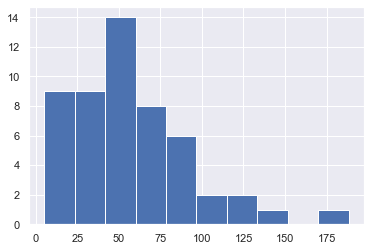

In [332]:
plt.hist(days_to_cancel['days_to_cancel'])
plt.show()

**Days between Registration and Downgrade**

In [328]:
# Time to Downgrade
days_to_downgrade = events.withColumn('downgradeTs', when(col('page') == 'Submit Downgrade', events.ts).otherwise(0)) \
    .groupby('userId', 'registration') \
    .agg(Fmax('downgradeTs').alias('downgradeTs')) \
    .withColumn('days_to_downgrade', when(col('downgradeTs') > 0, (col('downgradeTs') - col('registration'))/86400/1000).otherwise(0)) \
    .filter(col('days_to_downgrade') > 0) \
    .toPandas()

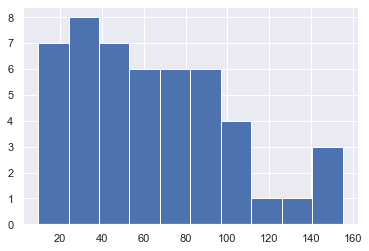

In [329]:
plt.hist(days_to_downgrade['days_to_downgrade'])
plt.show()

**Average daily Events per User**

**Songs per Day**

**Artists per Month**

**Length per Song**

In [180]:
# Check which Page types provide "length"
events.filter('length is not Null').select(['Page']).dropDuplicates().show()

+--------+
|    Page|
+--------+
|NextSong|
+--------+



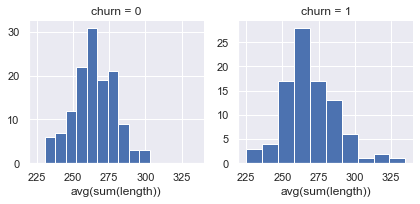

In [186]:
# Plot average length per song
song_length = events.filter('Page == "NextSong"') \
    .groupby(['churn', 'userId', 'song']) \
    .sum('length') \
    .groupby(['userId', 'churn']) \
    .agg({'sum(length)': 'avg'}).toPandas()

g = sns.FacetGrid(song_length, col="churn", sharey=False)
g.map(plt.hist, "avg(sum(length))");

In [175]:
songs_per_session

,userId,churn,avg(count)
0,19,0,216.000000
1,200007,0,32.500000
2,100005,1,38.500000
3,300007,1,111.000000
4,200002,0,64.500000
...,...,...,...
220,136,0,106.200000
221,53,1,83.142857
222,122,1,13.666667
223,59,1,120.666667


In [170]:
events.groupBy(['userId','churn']).agg(Fmax('itemInSession').alias('itemInSession')).toPandas()

,userId,churn,itemInSession
0,19,0,280
1,100005,1,73
2,200007,0,48
3,300007,1,142
4,25,1,713
...,...,...,...
220,53,1,458
221,136,0,654
222,59,1,286
223,122,1,43


In [ ]:

# Similar to length, we visualize the distribution between both groups
item_df = events.groupBy(['userId','churn']).avg('itemInSession').toPandas()
g = sns.FacetGrid(item_df, col="churn", sharey=False)
g.map(plt.hist, "avg(itemInSession)");


In [128]:
# Prozentuale Verteilung Eventtypen in beiden gruppen pro nutzer im durchschnitt

In [ ]:
events.filter('Page == "Thumbs Down"') \
    .groupby('userId') \
    .agg({'userId': 'count', 'churn': 'max'}) \
    .withColumnRenamed("max(churn)", "churn") \
    .groupBy('churn') \
    .agg(avg('count(userId)').alias('users')) \
    .toPandas()

In [58]:
events.filter('churn == 0 and Page == "Thumbs Down"') \
    .groupby('userId') \
    .agg({'userId': 'count'}) \
    .agg({'count(userId)':'avg'}) \
    .collect()[0]['avg(count(userId))']

9.956521739130435

In [68]:
# How many songs do users listen to on average between visiting our home page
function = udf(lambda ishome : int(ishome == 'Home'), IntegerType())

user_window = Window \
    .partitionBy('userID') \
    .orderBy(desc('ts')) \
    .rangeBetween(Window.unboundedPreceding, 0)

cusum = events.filter((events.page == 'NextSong') | (events.page == 'Home')) \
    .select('userID', 'page', 'ts', 'churn') \
    .withColumn('homevisit', function(col('page'))) \
    .withColumn('period', Fsum('homevisit').over(user_window))

cusum.filter((cusum.page == 'NextSong')) \
    .groupBy('userID', 'period') \
    .agg({'period':'count', 'churn': 'max'}) \
    .groupBy('max(churn)') \
    .agg({'count(period)':'avg'}).show()

+----------+------------------+
|max(churn)|avg(count(period))|
+----------+------------------+
|         1|  23.4531122031122|
|         0|23.757949790794978|
+----------+------------------+



In [ ]:
# Level 



In [213]:
# User Agent



In [ ]:
# Gender



# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.